<a href="https://colab.research.google.com/github/sanglee/BIML2021/blob/main/BIML21_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BIML 2021 (Introduction to SVM)

@author: Sangkyun Lee  (sangkyun@korea.ac.kr)



### Supplementary Notes
---

In [ ]:
# A utility function to plot decision boundaries in 2D

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)]*sum(y == cl),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

---
### Loading the IRIS data

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', names= ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Label'])

In [ ]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Prepare data matrix and labels

import numpy as np
from sklearn.preprocessing import LabelEncoder

feat_idx = [2,3]
feat_labels = df.columns[feat_idx]
X = df.iloc[:, feat_idx].values
y = df.iloc[:, 4].values
enc_y = LabelEncoder()
enc_y.fit(y)
y = enc_y.transform(y)
feature_names = df.columns.values[[2,3]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

---
## Support Vector Machine (SVM)


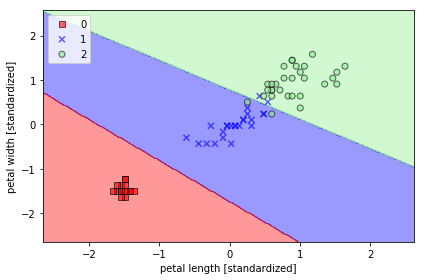

Train accuracy: 0.945205
Test accuracy: 0.977778


In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

svm = SVC(decision_function_shape='ovr', kernel='linear', C=10.0)

svm.fit(X_train_std, y_train)           # standardization is recommended for numerical reasons here

plot_decision_regions(X_train_std,           
                      y_train,
                      classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

### Feature Importance

- Linear models (logistic regression, linear SVM, perceptron, ...)
  - Prediction for an input $x^{(i)}$ is produced by $\hat y^{(i)} = f(w^T x^{(i)})$, where $f$ is some function, e.g., to convert linear output to binary outcome.
  - $w^T x^{(i)} = \sum_{j=1}^p w_j x^{(i)}_j$ 
  - We call $w_1, w_2, \dots, w_p$ as **coefficients**, **weights**, or **learning parameters**
  - In scikit-learn, `<model>.coef_` contains the coefficients
  
- Non-linear models (decision trees, random forest, nonlinear SVM, ...)
  - This type of models provides other ways to measure feature importance
    - DT, RF: `<model>.feature_importances_`
  - In some models, it is not easy to extract feature importance
    - Nonlinear SVM

In [ ]:
print(svm.coef_)

imporant_feat = pd.DataFrame(np.abs(svm.coef_))
imporant_feat.columns = feat_labels
imporant_feat

[[-1.06139348 -1.1489091 ]
 [-0.57330686 -0.57625103]
 [-2.65965384 -4.01574174]]


,Petal Length,Petal Width
0,1.061393,1.148909
1,0.573307,0.576251
2,2.659654,4.015742


---
## Nonlinear Classification

### XOR Toy Data

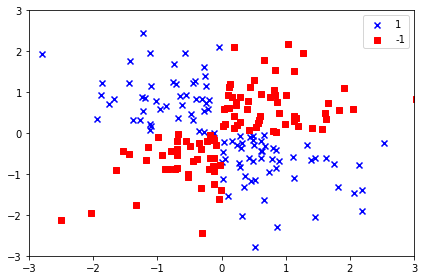

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### SVM on XOR data

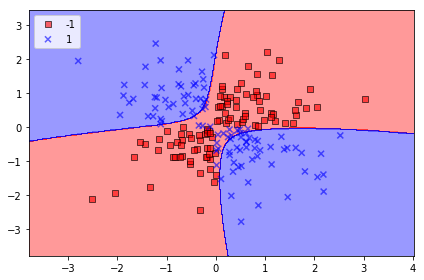

In [ ]:
#
# SVM on XOR data
#
svm = SVC(kernel='rbf', random_state=1, gamma=.1, C=10)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Support Vectors

In [ ]:
svm.support_
#svm.support_vectors_
#svm.n_support_

array([  6,   8,   9,  13,  17,  20,  23,  24,  36,  40,  41,  42,  44,
        45,  47,  58,  60,  65,  69,  70,  72,  73,  78,  92,  93, 109,
       111, 113, 114, 115, 117, 120, 121, 125, 132, 133, 141, 142, 143,
       145, 147, 160, 166, 173, 190, 193,   4,  14,  18,  22,  25,  27,
        31,  32,  38,  43,  48,  52,  54,  77,  79,  81,  82,  86,  87,
        89,  94, 100, 108, 123, 127, 129, 130, 131, 134, 139, 144, 146,
       153, 158, 161, 164, 171, 172, 176, 178, 182, 185, 186, 192, 196,
       199], dtype=int32)

In [ ]:
svm.dual_coef_

array([[-10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        ,  -7.99986544, -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        ,  -6.20496694, -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        ,  -1.56513305,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.        ,  10.        ,
         10.        ,  10.        ,  10.

### SVM on IRIS data

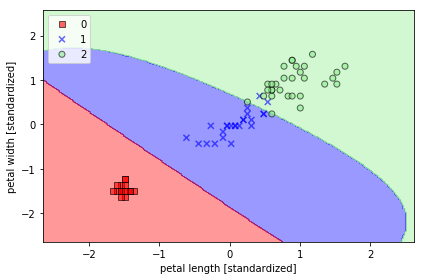

Train accuracy: 0.945205
Test accuracy: 0.977778


In [ ]:

from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.2, C=1.0)  # gamma=100.0, C=1.0
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std, y_train, classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

---
## K-Fold Cross Valiation (CV)

In [ ]:
from sklearn.model_selection import cross_val_score

C_grid = [0.1, 1, 10]
cv_err = []

for c in C_grid:
    scores = cross_val_score(estimator=SVC(C=c),
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1)  # no. cpu cores to use. -1 all cores
    print('C = %f' % c)
    print('CV accuracy scores:\n %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print('--------------------------------------------------------------------')
    cv_err.append(np.mean(scores))
    
best_idx = np.argmax(cv_err)
print(best_idx)
best_C = C_grid[best_idx]

print('Best C due to CV: %f' % best_C)

C = 0.100000
CV accuracy scores:
 [1.         0.93333333 0.93333333 0.86666667 1.        ]
CV accuracy: 0.947 +/- 0.050
--------------------------------------------------------------------
C = 1.000000
CV accuracy scores:
 [1.         0.93333333 0.93333333 0.86666667 1.        ]
CV accuracy: 0.947 +/- 0.050
--------------------------------------------------------------------
C = 10.000000
CV accuracy scores:
 [1.         0.93333333 0.86666667 0.86666667 1.        ]
CV accuracy: 0.933 +/- 0.060
--------------------------------------------------------------------
0
Best C due to CV: 0.100000
